In [2]:
import sys
assert sys.version_info >= (3,7)

In [3]:
from packaging import version
import sklearn
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size = 14)
plt.rc("axes", labelsize = 14, titlesize = 14)
plt.rc("legend", fontsize = 14)
plt.rc("xtick", labelsize = 10)
plt.rc("ytick", labelsize = 10)

### Linear Regression

#### The Normal Equation

In [5]:
import numpy as np

np.random.seed(42)
m = 100
X = 2 * np.random.rand(m , 1)
y = 4 + 3 * X + np.random.rand(m, 1)


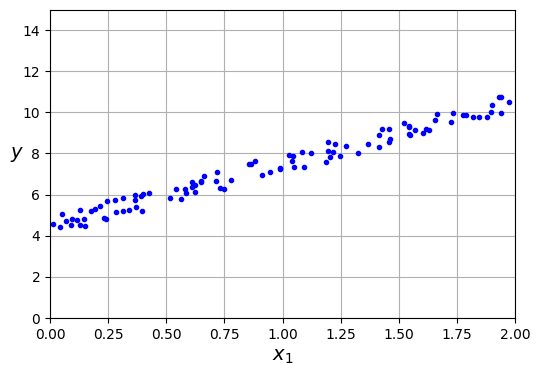

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation = 0)
plt.grid()
plt.axis([0,2,0,15])

plt.show()

In [7]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
theta_best

array([[4.51359766],
       [2.98323418]])

In [8]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ theta_best
y_predict

array([[ 4.51359766],
       [10.48006601]])

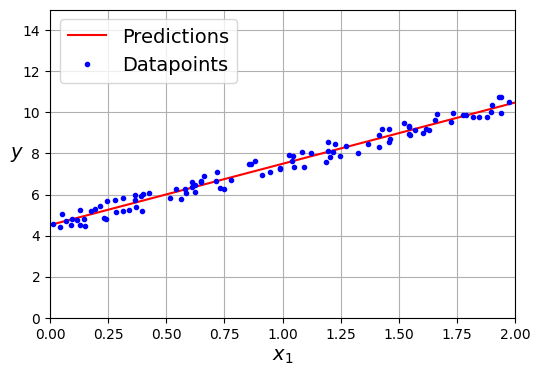

In [9]:
plt.figure(figsize=(6,4))
plt.plot(X_new, y_predict, "r-", label="Predictions")
plt.plot(X,y, "b.", label = "Datapoints")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation = 0)
plt.grid()
plt.axis([0,2,0,15])
plt.legend(loc="upper left")

plt.show()

In [10]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.51359766]), array([[2.98323418]]))

In [11]:
lin_reg.predict(X_new)

array([[ 4.51359766],
       [10.48006601]])